In [55]:
import os
import pandas as pd


In [56]:
folder = "../results"
results_datasets = [
    "baseline_measurements.parquet",
    "bilateral.parquet",
    "blur.parquet",
    "gaussblur.parquet",
    "mean.parquet",
    "medianblur.parquet",
    "nml_fastnl.parquet",
    "nml_multi_fastnl.parquet",
    "pca.parquet",
]


In [105]:
# Read and join all result sets
results = []
for file in results_datasets:
    file_path = os.path.join(folder, file)
    results.append(pd.read_parquet(file_path))

results = pd.concat(results, axis="index").reset_index()
results = results.groupby(
    by=["denoise_function", "img_id", "noise_type"], as_index=False
).agg(
    mse=("mse", "mean"),
    ssim=("ssim", "mean"),
    psnr=("psnr", "mean"),
)

In [106]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   denoise_function  2700 non-null   object 
 1   img_id            2700 non-null   int64  
 2   noise_type        2700 non-null   object 
 3   mse               2700 non-null   float64
 4   ssim              2700 non-null   float64
 5   psnr              2700 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 126.7+ KB


In [136]:
def normalize_results(
    df: pd.DataFrame, category_field: str, baseline_category: str
) -> pd.DataFrame:
    results = df.copy()

    dims = set(results[category_field].unique())
    # dims.remove(baseline_category)
    baseline = results.loc[results[category_field] == baseline_category, ["mse", "ssim", "psnr"]]

    for dim in dims:
        results.loc[results[category_field] == dim, ["mse", "ssim", "psnr"]] = (
            results.loc[results[category_field] == dim, ["mse", "ssim", "psnr"]] / baseline
        )

    return results


results_normalized = normalize_results(results.set_index(["img_id", "noise_type"]), "denoise_function", "None")

In [141]:
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns


def plot_scatter(
    df: pd.DataFrame,
    x: str,
    y: str,
    hue: str,
    plot_title: str = "Scatter Plot",
    alpha: float = 0.8,
):
    plt.figure(figsize=(12, 7))
    sns.stripplot(df, x=x, y=y, hue=hue, alpha=alpha)
    plt.ylim(0, 2)
    plt.title(plot_title)
    plt.legend()
    plt.show()

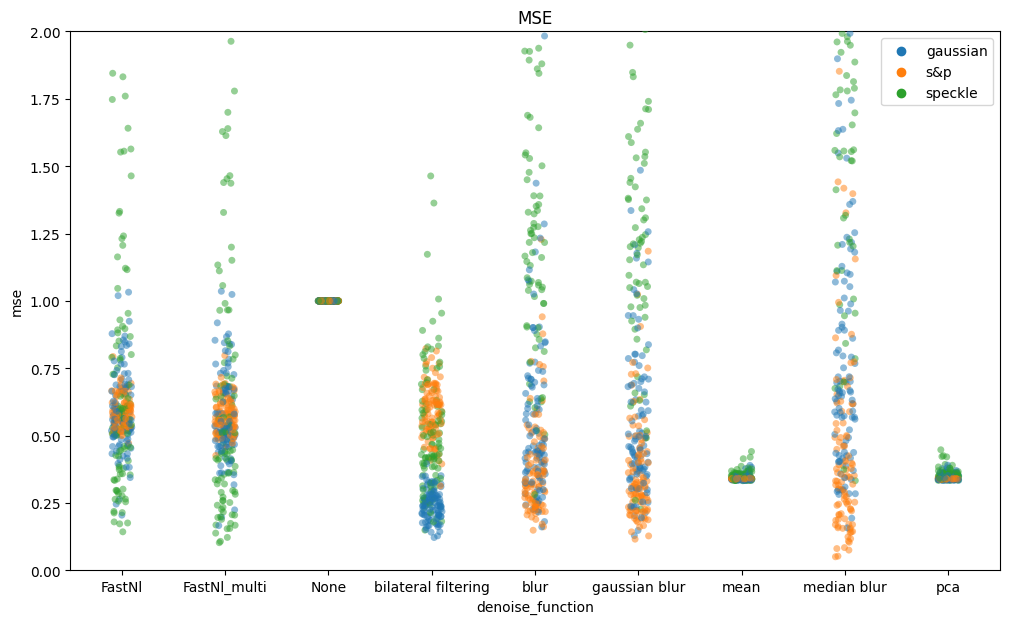

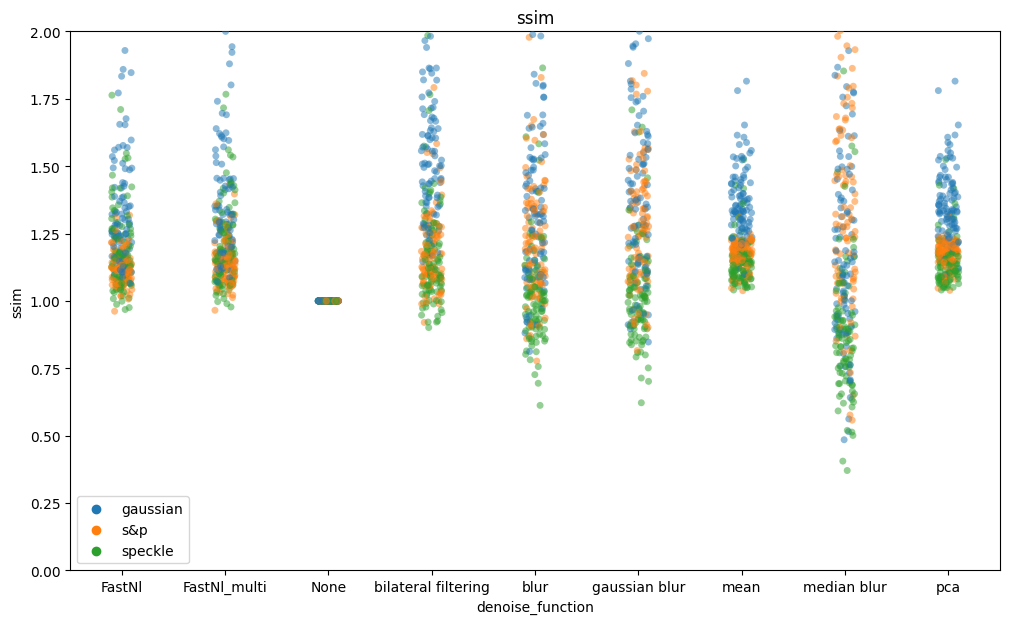

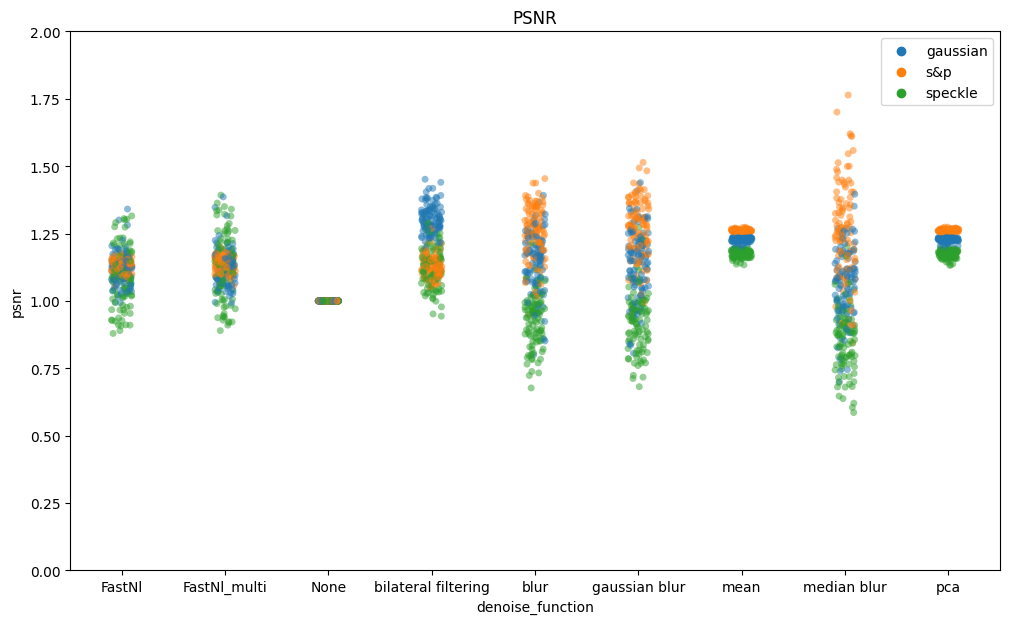

In [142]:
plot_scatter(
    results_normalized.reset_index(),
    x="denoise_function",
    y="mse",
    alpha=0.5,
    hue="noise_type",
    plot_title="MSE",
)
plot_scatter(
    results_normalized.reset_index(),
    x="denoise_function",
    y="ssim",
    alpha=0.5,
    hue="noise_type",
    plot_title="ssim",
)
plot_scatter(
    results_normalized.reset_index(),
    x="denoise_function",
    y="psnr",
    alpha=0.5,
    hue="noise_type",
    plot_title="PSNR",
)

## Notes
1. Bluring techniques do better with S&P noise as seen using MSE and PSNR metrics
2. Mean/PCA provides extremely consistent and similar results
3. Bilateral filtering handles gaussian noise very well.
4. Non-local means provides consistent results for S&P noise
5. Speckle (multiplicative) noise is generally the most difficult to reduce.